In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF, batched_RBF, batched_MGGP_RBF
from gpzoo.gp import GaussianPrior, SVGP, VNNGP, MGGP_WSVGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2, Hybrid_NSF_Exact
from gpzoo.utilities import whitened_KL, train_hybrid, train_hybrid_batched, anndata_to_train_val, rescale_spatial_coords, add_jitter, scanpy_sizefactors, init_softplus
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle
from sklearn.cluster import KMeans

import matplotlib.patheffects as path_effects

import pandas as pd

import anndata

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 90)
    min_val = np.percentile(factors, 10)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//6, i%6]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
            
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
matrix_csv = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_by_gene_goodgenes_noblanks.csv'

In [4]:
annotations_file = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/Merged_clustering_Anannotated.h5ad'

In [5]:
metadata_csv = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_metadata.csv'

In [6]:
df = pd.read_csv(matrix_csv, index_col=0)
meta_df = pd.read_csv(metadata_csv, index_col=0)

In [7]:
adata = anndata.read_h5ad(annotations_file)

In [8]:
adata

AnnData object with n_obs × n_vars = 754866 × 500
    obs: 'cell', 'n_genes_by_counts', 'total_counts', 'n_counts', 'kmeans11', 'kmeans12', 'kmeans13', 'kmeans14', 'kmeans15', 'kmeans16', 'kmeans17'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'kmeans11_colors', 'kmeans12_colors', 'kmeans13_colors', 'kmeans14_colors', 'kmeans15_colors', 'kmeans16_colors', 'kmeans17_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


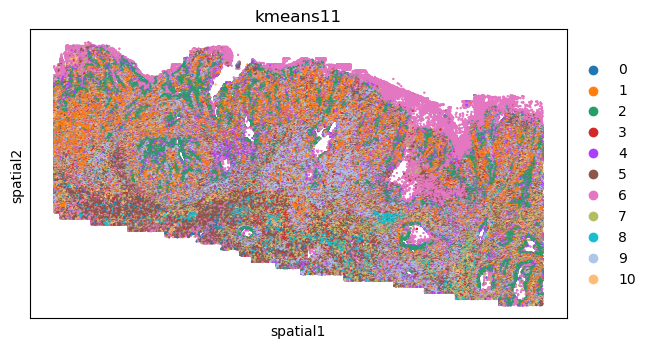

In [9]:
sq.pl.spatial_scatter(adata, color='kmeans11', size=1, shape=None);

In [10]:
X = rescale_spatial_coords(adata.obsm['spatial'])*50
X = X[::10]
Y = np.exp(adata.X.T)/30
Y = Y[:, ::10]
V = scanpy_sizefactors(Y.T)

In [11]:
nmf_model = NMF(n_components=24, max_iter=10, init='random', random_state=4, alpha_H=2e-1, alpha_W=1e-7)

In [12]:
nmf_model.fit(Y.T/V)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=10, n_components=24,
    random_state=4)

In [13]:
exp_factors = nmf_model.transform(Y.T/V)/5
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T*5

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [14]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [15]:
np.round(moranI,2)

array([ 0.13,  0.07,  0.05,  0.04,  0.03,  0.02,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ])

In [16]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

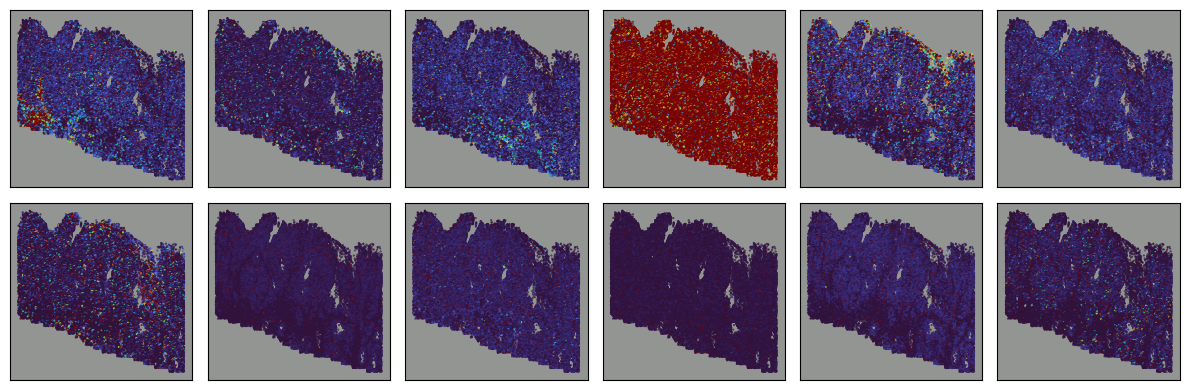

In [17]:
plot_factors(np.exp(factors_ordered.T)[:12], X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [18]:
len(X)

75487

In [19]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)
groupsX = torch.tensor(adata.obs['kmeans11'].values[::10].codes).type(torch.LongTensor)
n_groups = len(adata.obs['kmeans11'].values.categories)

In [20]:
torch.unique(groupsX, return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 tensor([ 1439, 17452,  9389,  2344, 13235,  5555,  7007,  3852,  2446, 10460,
          2308]))

<BarContainer object of 11 artists>

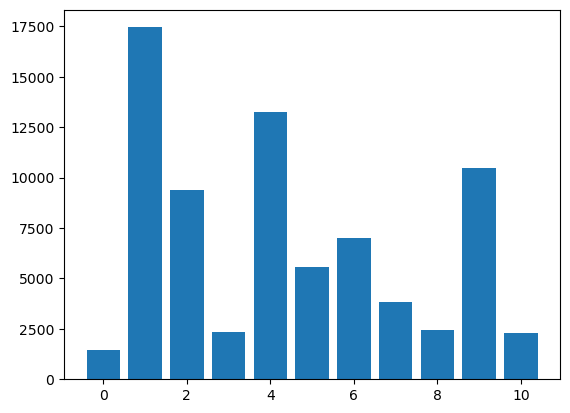

In [21]:
plt.bar(*torch.unique(groupsX, return_counts=True))

In [22]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [23]:
def build_model(Y, M=215, L=10):
    

    torch.manual_seed(0)



    groupsX = torch.tensor(adata.obs['kmeans11'].values.codes[::10]).type(torch.LongTensor)
    n_groups = len(adata.obs['kmeans11'].values.categories)

    scale = len(groupsX)/M

    Z = []
    groupsZ = []
    for i in range(n_groups):
        mask = groupsX==i
    
        number_clusters = (int(sum(mask)/scale))
        kmeans = KMeans(n_clusters=number_clusters, random_state=240, n_init="auto").fit(X[mask])
        Z.append(kmeans.cluster_centers_)
        groupsZ += number_clusters*[i]
    Z = np.concatenate(Z)

    
    Z = nn.Parameter(torch.tensor(Z).type(torch.float), requires_grad=False)
    groupsZ = nn.Parameter(torch.tensor(groupsZ).type(torch.LongTensor), requires_grad=False)

    M = len(Z) #new M which should be close to original M

    
    
    kernel = batched_MGGP_RBF(sigma=[1.0]*L, lengthscale=[2.0]*L, group_diff_param=[2.0]*L, n_groups=n_groups)

    gp = MGGP_WSVGP(kernel, M=M, n_groups=n_groups, jitter=1e-5)

    
    Kzx = kernel.forward(Z, X, groupsZ, groupsX).contiguous()
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z, groupsZ, groupsZ).contiguous()

    Lzz = torch.linalg.cholesky(add_jitter(Kzz, 1e-5))
    Lzzt = torch.transpose(Lzz, -2, -1)

        


    

    all_factors = torch.tensor(factors_ordered.T)[:L, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx@Kxz, 1e-3))
    

    solved1 = torch.cholesky_solve(Kzx@all_factors, L1)
    print('solved1 shape:', solved1.shape)
    
    
    mu = Lzzt@solved1

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)



    # # get values for Lu (whitened)
    # Wt = torch.linalg.solve_triangular(Lzz, Kzx, upper=False)
    # W = torch.transpose(Wt, -2, -1)
    # outers = torch.vmap(torch.vmap(lambda x:torch.outer(x, x).view(-1)))(W)
    # outers_matmul = torch.transpose(outers, -2, -1) @ outers
    
    # outers_chol = torch.cholesky(add_jitter(outers_matmul, 1e-5))
    
    # outers_solv = torch.cholesky_solve(torch.transpose(outers, -1, -2), outers_chol)



    
    # all_factors_exp = all_factors.exp()
    # all_factors_exp = all_factors_exp/all_factors_exp.amax(dim=1, keepdim=True)

    
    
    # S = torch.squeeze(outers_solv @ (1-all_factors_exp))

    # S = torch.vmap(lambda x: x.reshape(M, M))(S)

    # Lu = torch.cholesky(add_jitter(S, 1e-5))


    
    
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = Z
    gp.groupsZ = groupsZ

    prior = GaussianPrior(Y, L=L)
    prior.mean = nn.Parameter(torch.squeeze(torch.tensor(factors_ordered[:, L:].T)).clone().detach().type(torch.float))

    

    model = Hybrid_NSF2(gp, prior, Y, L=L, T=L)


    model.sf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, :L]).type(torch.float)) 
    model.cf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, L:]).type(torch.float)) 


    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float))) 
    
    # model.to(device)
    return model

In [24]:
model = build_model(Y, L=12, M=5000)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3c301c8c10>
Traceback (most recent call last):
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has n

solved1 shape: torch.Size([12, 4994, 1])
here


In [25]:
model.load_state_dict(torch.load('colon_mggp_nsf_5000.pth'))

<All keys matched successfully>

In [26]:
#we precompute W, in case we dont want to train kernel parameters
Z = model.sf.prior.Z
groupsZ = model.sf.prior.groupsZ
groupsX = torch.tensor(adata.obs['kmeans11'].values[::10].codes).type(torch.LongTensor)


kernel = model.sf.prior.kernel

Kzx = kernel.forward(Z, X, groupsZ, groupsX).contiguous()
Kxz = torch.transpose(Kzx, -2, -1)
Kzz = kernel.forward(Z, Z, groupsZ, groupsZ).contiguous()

Lzz = torch.linalg.cholesky(add_jitter(Kzz, 1e-5))
Wt = torch.linalg.solve_triangular(Lzz, Kzx, upper=False)
W = torch.transpose(Wt, -2, -1).detach()

In [27]:
# all_factors = torch.tensor(factors_ordered.T)[:12, :, None].type(torch.float)
# all_factors_exp = all_factors.exp()
# all_factors_exp = all_factors_exp/all_factors_exp.amax(dim=1, keepdim=True)
# all_factors_exp = torch.squeeze(all_factors_exp)

# Lz = 1e-2*torch.eye(len(Z)).expand(12, len(Z), len(Z)).type(torch.float)
# Lz_mat = torch.tensor(Lz.detach().clone(), requires_grad=True, device=device)

In [28]:
# optimizer = torch.optim.Adam([Lz_mat], lr=1e-3)

In [29]:

# # Training loop
# num_iterations = 1000
# losses = []
# for iteration in tqdm(range(num_iterations)):
#     optimizer.zero_grad()
    

#     Lz_corrected = Lz_mat.tril(-1) + Lz_mat.diagonal(dim1=-2, dim2=-1).exp().diag_embed()

#     idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=6000, replacement=False).detach()

#     W_batch = W[:, idx].detach()
#     all_factors_exp_batch = all_factors_exp[:, idx].detach()

#     all_factors_exp_batch = all_factors_exp_batch.to(device)
#     W_batch = W_batch.to(device)

#     sigma_hat = torch.sum((W_batch@Lz_corrected)**2, dim=-1)

    
#     # Compute the loss

#     goal = (torch.sum(W_batch**2, dim=-1)-1) + 2*(1 - all_factors_exp_batch)

    
#     loss = torch.mean((sigma_hat - goal) ** 2)
    
#     # Backpropagation
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

#     del W_batch
#     del all_factors_exp_batch

#     losses.append(loss.item())


In [30]:
# plt.plot(losses)

In [31]:
# model.sf.prior.Lu = nn.Parameter(Lz_mat.detach().cpu().clone())

In [32]:
model.cpu()


qF, _, _ = model.sf.prior.forward_precomputed(W)

mean = torch.exp(qF.mean).detach().numpy()
scale = qF.scale.detach().numpy()

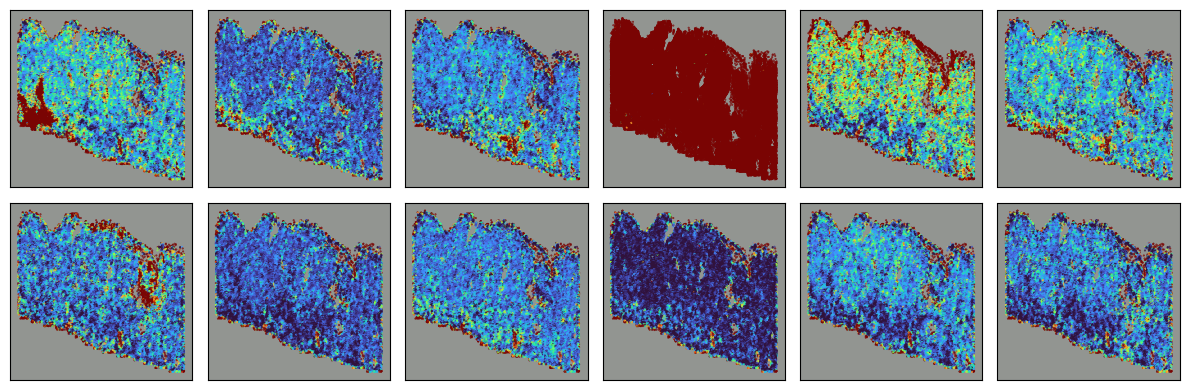

In [33]:
plot_factors(mean, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


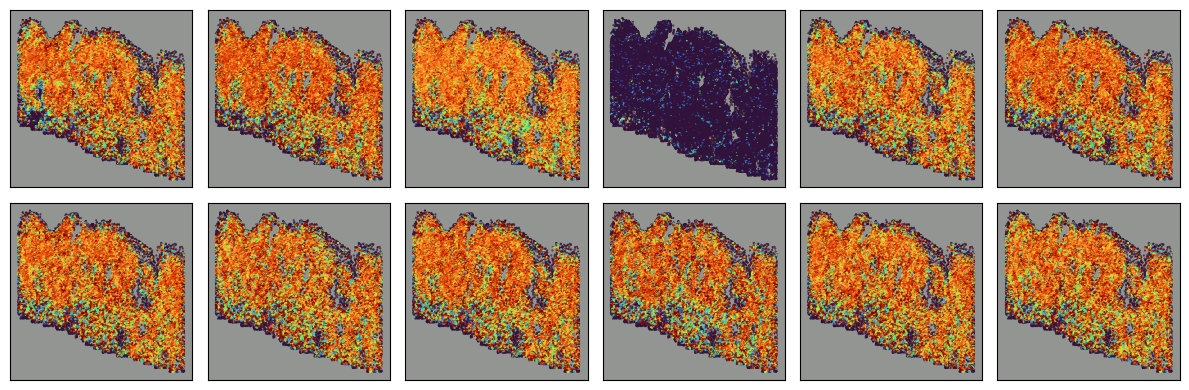

In [34]:
plot_factors(scale, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [69]:
loadings_sf = torch.nn.functional.softplus(model.sf.W).detach().cpu()
loadings_cf = torch.nn.functional.softplus(model.cf.W).detach().cpu()

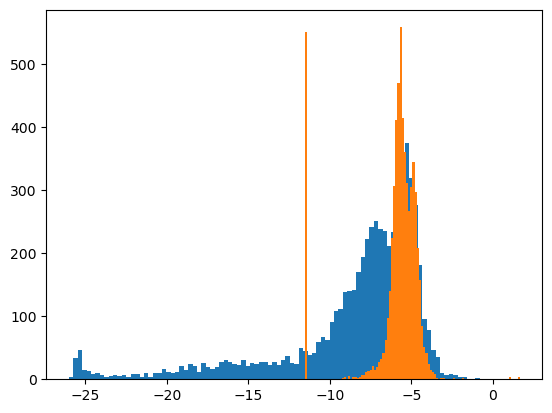

In [70]:
plt.hist(torch.log(loadings_sf.view(-1)), bins=100);
plt.hist(torch.log(loadings_cf.view(-1)), bins=100);

In [38]:
X_train = X.to(device)
Y_train = Y.to(device)
groupsX_train = groupsX.to(device)

In [39]:
def model_grads(model):
    model.sf.prior.kernel.sigma.requires_grad = False
    model.sf.prior.kernel.lengthscale.requires_grad = False
    model.sf.prior.kernel.group_diff_param.requires_grad = False
    model.sf.prior.Z.requires_grad=False
    model.sf.prior.mu.requires_grad=True
    model.sf.prior.Lu.requires_grad=True
    model.sf.W.requires_grad=True

    model.cf.prior.mean.requires_grad=False
    model.cf.prior.scale.requires_grad=True
    model.cf.W.requires_grad=False

    model.cf.prior.scale_pf = 0.5
    
    
    model.V.requires_grad=False

In [40]:
model_grads(model)

In [41]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [42]:
def train_precomputed(model, optimizer, W, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(W.shape[1]), num_samples=batch_size, replacement=False)

        W_batch = W[:, idx]

        W_batch = W_batch.to(device)
        
        optimizer.zero_grad()
        pY, qF, qU, pU, qF2, pF2 = model.forward_precomputed(W=W_batch, idx=idx, E=E, **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(torch.vmap(whitened_KL)(qU.mean, qU.scale_tril))

        ELBO -= torch.sum(distributions.kl_divergence(qF2, pF2))
        
        loss = -ELBO

        loss += 50.0*torch.sum(model.sf.prior.kernel.lengthscale**2) 
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        del W_batch
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [43]:
model.sf.prior.jitter=1e-6

In [62]:
steps = 3000*4
model.to(device)

Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): MGGP_WSVGP(
      (kernel): batched_MGGP_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [ ]:
losses, means, scales, idxs = train_precomputed(model, optimizer, W, Y_train, device, steps=steps, E=3, batch_size=7000)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
def model_grads2(model):
    model.sf.prior.kernel.sigma.requires_grad = False
    model.sf.prior.kernel.lengthscale.requires_grad = False
    model.sf.prior.kernel.group_diff_param.requires_grad = False
    model.sf.prior.Z.requires_grad=False
    model.sf.prior.mu.requires_grad=True
    model.sf.prior.Lu.requires_grad=True
    model.sf.W.requires_grad=True

    model.cf.prior.mean.requires_grad=True
    model.cf.prior.scale.requires_grad=True
    model.cf.W.requires_grad=True

    model.cf.prior.scale_pf = 0.5
    
    
    model.V.requires_grad=False

In [ ]:
model_grads2(model)

In [79]:
steps = 3000
model.to(device)

Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): MGGP_WSVGP(
      (kernel): batched_MGGP_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [80]:
losses, means, scales, idxs = train_precomputed(model, optimizer, W, Y_train, device, steps=steps, E=3, batch_size=7000)

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

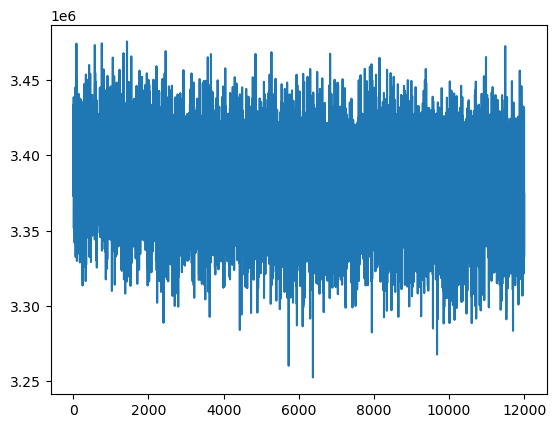

In [78]:
plt.plot(losses)

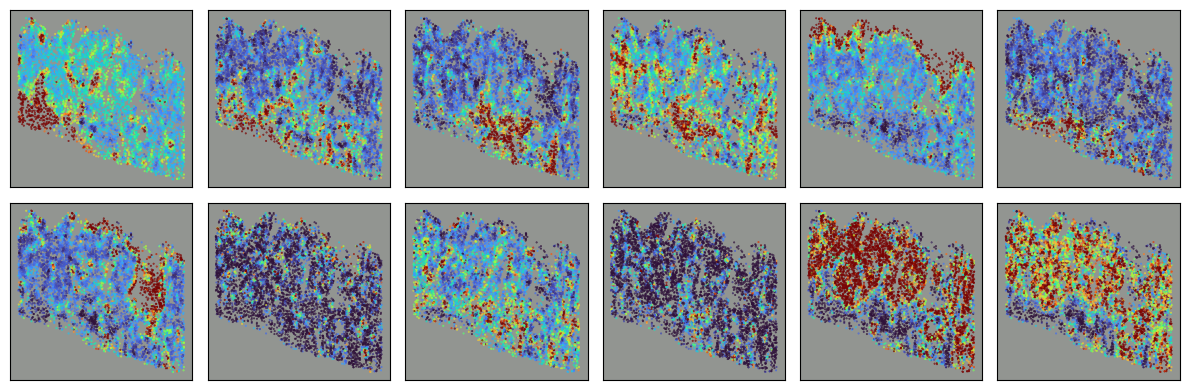

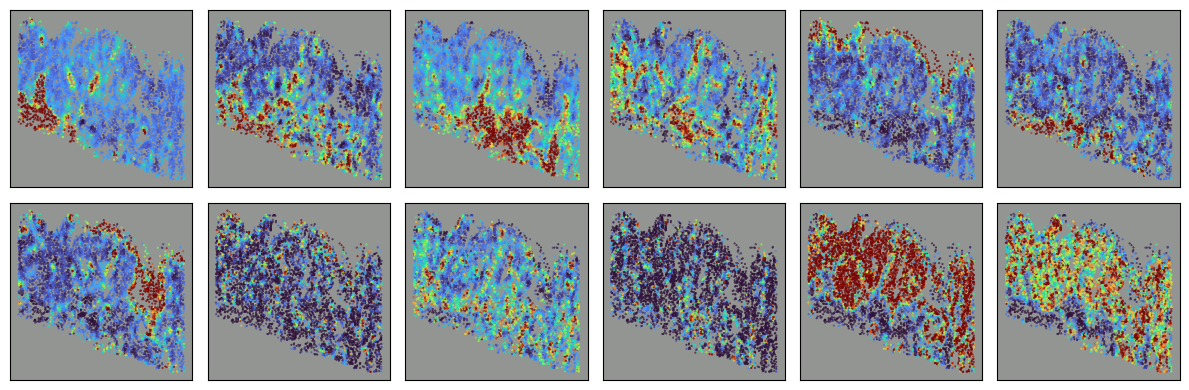

In [71]:
plot_factors(means[0], X[idxs[0]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)
plot_factors(means[-1], X[idxs[-1]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [81]:
model.cpu()

qF2, _ = model.cf.prior()
mean2 = torch.exp(qF2.mean).detach().numpy()
scale2 = qF2.scale.detach().numpy()

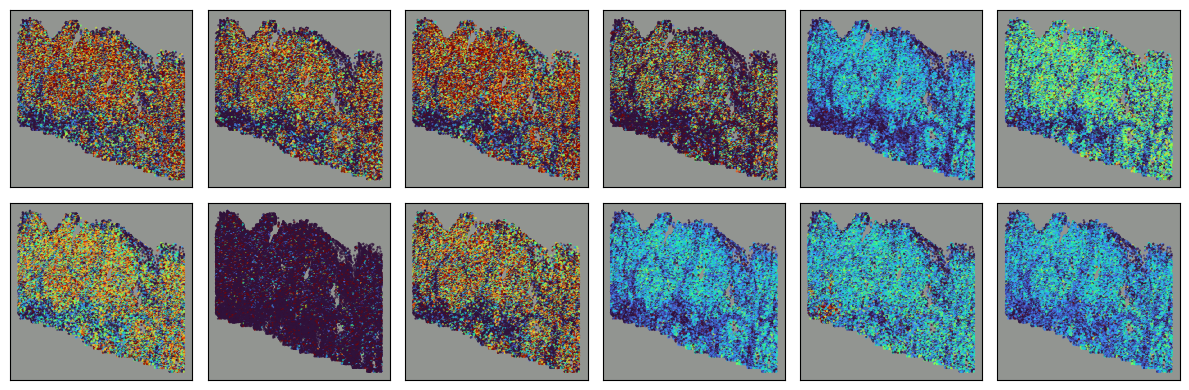

In [74]:
plot_factors(mean2, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


In [82]:
full_factors = np.concatenate((mean, mean2))
full_loadings = torch.concatenate((torch.nn.functional.softplus(model.sf.W), (torch.nn.functional.softplus(model.cf.W))), dim=1)


In [83]:
def plot_top_genes(factors, loadings, X, y, num_genes= 5, size=2, alpha=0.8, s=0.1, names=None):

    max_val_factors = np.percentile(factors, 90)
    min_val_factors = np.percentile(factors, 10)

    L = len(factors)//2


    loadings_softmax = torch.nn.functional.softmax(loadings, dim=1)

    order = torch.argsort(loadings_softmax,dim=0, descending=True)

    y_top = y[order[:num_genes]]
    fig, ax = plt.subplots(L, num_genes+1, figsize=(size*(num_genes+1), size*L), tight_layout=True)

    for i in range(L):
        

        curr_ax = ax[i, 0]
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val_factors, vmax=max_val_factors, alpha=alpha, cmap='turbo', s=s)
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

        names = adata.var.index[order[:num_genes, i]]

        max_val_genes = np.percentile(y_top[:, i], 90)
        min_val_genes = np.percentile(y_top[:, i], 10)
        
        for j in range(num_genes):
            
            curr_ax = ax[i, j+1]
            curr_ax.scatter(X[:, 0], X[:,1], c=y_top[j, i], alpha=alpha, cmap='turbo', s=s, vmin = min_val_genes, vmax=max_val_genes)
            curr_ax.invert_yaxis()
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])
            curr_ax.set_facecolor('xkcd:gray')

            title_text = curr_ax.set_title(names[j], x=0.03, y=.88, fontsize="medium", c="white",
                         ha="left", va="top")

            title_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                                 path_effects.Normal()])
        

In [ ]:
plot_top_genes(full_factors, full_loadings, X, Y, size=2, alpha=0.9, s=0.2, num_genes=5)

In [ ]:
torch.save(model.state_dict(), 'colon_mggp_nsf_5000.pth')